# Raw data preparation

This notebook explains the data pre-processing pipeline on the public EURO 2020 dataset provided by StatsBomb. The following steps are performed:

- Create a local SQlite database for storing the data
- Convert StatsBomb events to SPADL actions
- Store SPADL actions and metadata in SQLite database


In [1]:
import os, sys
import tqdm
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

In [2]:
# Disable private API warnings
import warnings
from statsbombpy.api_client import NoAuthWarning
warnings.filterwarnings(action="ignore", category=NoAuthWarning, module='statsbombpy')

%load_ext autoreload
%autoreload 2

# from unxpass.databases import SQLiteDatabase
from unxpass.visualization import plot_action
from unxpass.databases import SQLiteDatabase
from typing import Optional,Union
from typing_extensions import Literal

from statsbombpy import sb

import matplotlib.pyplot as plt

/home/toc3/anaconda3/lib/python3.7/site-packages/requests/__init__.py:114: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4)/charset_normalizer (3.2.0) doesn't match a supported version!
  RequestsDependencyWarning,


/home/toc3/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
from pathlib import Path

# Disable private API warnings
import warnings
import tqdm
from statsbombpy.api_client import NoAuthWarning
from socceraction.data.statsbomb import StatsBombLoader
from statsbombpy import sb
import pandas as pd
from unxpass.visualization import plot_action
from unxpass.databases import SQLiteDatabase

SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

#StatsBomb360데이터에서는 3종류의 데이터만 지원함(2022월드컵, 20남자 유에파, 22여자 유에파)
competition = sb.competitions()
competition = competition[(competition['match_available_360'].notna()) & (competition['competition_gender']=='male')]


games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in competition.itertuples()
])

In [15]:
games

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3857256,106,43,Group Stage,3,2022-12-02 21:00:00,786,773,2,3,Stadium 974,Fernando Andrés Rapallini
1,3869151,106,43,Round of 16,4,2022-12-03 21:00:00,779,792,2,1,Ahmad bin Ali Stadium,Szymon Marciniak
2,3857257,106,43,Group Stage,3,2022-11-30 17:00:00,792,776,1,0,Al Janoub Stadium,Mustapha Ghorbal
3,3857258,106,43,Group Stage,1,2022-11-24 21:00:00,781,786,2,0,Lusail Stadium,Alireza Faghani
4,3857288,106,43,Group Stage,2,2022-11-26 12:00:00,777,792,0,1,Al Janoub Stadium,Daniel Siebert
...,...,...,...,...,...,...,...,...,...,...,...,...
46,3788742,43,55,Group Stage,1,2021-06-12 18:00:00,776,1835,0,1,Parken,Anthony Taylor
47,3788775,43,55,Group Stage,3,2021-06-23 18:00:00,908,772,0,5,Estadio de La Cartuja,Björn Kuipers
48,3788776,43,55,Group Stage,3,2021-06-23 18:00:00,790,789,3,2,Saint-Petersburg Stadium,Michael Oliver
49,3788743,43,55,Group Stage,1,2021-06-12 21:00:00,782,796,3,0,Saint-Petersburg Stadium,Antonio Miguel Mateu Lahoz


In [4]:
other_competition = sb.competitions()[sb.competitions()['match_available_360'].notna()]

other_games = pd.concat([SBL.games(row.competition_id, row.season_id) for row in other_competition.itertuples()])

In [5]:
other_games

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3857256,106,43,Group Stage,3,2022-12-02 21:00:00,786,773,2,3,Stadium 974,Fernando Andrés Rapallini
1,3869151,106,43,Round of 16,4,2022-12-03 21:00:00,779,792,2,1,Ahmad bin Ali Stadium,Szymon Marciniak
2,3857257,106,43,Group Stage,3,2022-11-30 17:00:00,792,776,1,0,Al Janoub Stadium,Mustapha Ghorbal
3,3857258,106,43,Group Stage,1,2022-11-24 21:00:00,781,786,2,0,Lusail Stadium,Alireza Faghani
4,3857288,106,43,Group Stage,2,2022-11-26 12:00:00,777,792,0,1,Al Janoub Stadium,Daniel Siebert
...,...,...,...,...,...,...,...,...,...,...,...,...
59,3893800,107,72,Group Stage,1,2023-07-24 09:00:00,855,1204,1,0,Eden Park,Melissa Paola Borjas Pastrana
60,3893799,107,72,Group Stage,1,2023-07-24 11:30:00,857,2391,6,0,AAMI Park,Tori Penso
61,3893796,107,72,Group Stage,1,2023-07-23 08:00:00,858,1216,2,1,Wellington Regional Stadium,Katja Koroleva
62,3893795,107,72,Group Stage,1,2023-07-22 15:00:00,853,1207,1,0,HBF Park,Marie-Soleil Beaudoin


In [6]:
sb.competitions()[sb.competitions()['season_name'] == '2015/2016']

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-08-17T23:51:11.837478,None,None,2023-08-17T23:51:11.837478
4,16,27,Europe,Champions League,male,False,False,2015/2016,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
40,11,27,Spain,La Liga,male,False,False,2015/2016,2023-07-24T21:52:42.890908,2021-06-13T16:17:31.694,None,2023-07-24T21:52:42.890908
55,7,27,France,Ligue 1,male,False,False,2015/2016,2023-08-31T19:38:46.331149,None,None,2023-08-31T19:38:46.331149
58,2,27,England,Premier League,male,False,False,2015/2016,2023-07-12T13:59:45.191483,2021-06-13T16:17:31.694,None,2023-07-12T13:59:45.191483
60,12,27,Italy,Serie A,male,False,False,2015/2016,2023-08-31T16:46:34.290341,None,None,2023-08-31T16:46:34.290341


In [6]:
competition

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
26,43,106,International,FIFA World Cup,male,False,True,2022,2023-08-12T16:44:27.619465,2023-08-17T15:55:15.164685,2023-08-17T15:55:15.164685,2023-08-12T16:44:27.619465
35,11,90,Spain,La Liga,male,False,False,2020/2021,2023-07-26T14:11:01.312143,2023-07-26T14:15:15.217027,2023-07-26T14:15:15.217027,2023-07-26T14:11:01.312143
62,55,43,Europe,UEFA Euro,male,False,True,2020,2023-02-24T21:26:47.128979,2023-04-27T22:38:34.970148,2023-04-27T22:38:34.970148,2023-02-24T21:26:47.128979


In [6]:
games

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3857256,106,43,Group Stage,3,2022-12-02 21:00:00,786,773,2,3,Stadium 974,Fernando Andrés Rapallini
1,3869151,106,43,Round of 16,4,2022-12-03 21:00:00,779,792,2,1,Ahmad bin Ali Stadium,Szymon Marciniak
2,3857257,106,43,Group Stage,3,2022-11-30 17:00:00,792,776,1,0,Al Janoub Stadium,Mustapha Ghorbal
3,3857258,106,43,Group Stage,1,2022-11-24 21:00:00,781,786,2,0,Lusail Stadium,Alireza Faghani
4,3857288,106,43,Group Stage,2,2022-11-26 12:00:00,777,792,0,1,Al Janoub Stadium,Daniel Siebert
...,...,...,...,...,...,...,...,...,...,...,...,...
46,3788742,43,55,Group Stage,1,2021-06-12 18:00:00,776,1835,0,1,Parken,Anthony Taylor
47,3788775,43,55,Group Stage,3,2021-06-23 18:00:00,908,772,0,5,Estadio de La Cartuja,Björn Kuipers
48,3788776,43,55,Group Stage,3,2021-06-23 18:00:00,790,789,3,2,Saint-Petersburg Stadium,Michael Oliver
49,3788743,43,55,Group Stage,1,2021-06-12 21:00:00,782,796,3,0,Saint-Petersburg Stadium,Antonio Miguel Mateu Lahoz


In [17]:
games[games.game_id==3869685]

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
9,3869685,106,43,Final,7,2022-12-18 17:00:00,779,771,3,3,Lusail Stadium,Szymon Marciniak


In [7]:
games[games.game_id.isin([3788751, 3788762, 3794691, 3857261, 3857263, 3857273, 3857295, 3869220, 3869684])]

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
18,3869684,106,43,3rd Place Final,7,2022-12-17 17:00:00,785,788,2,1,Sheikh Khalifa International Stadium,Abdulrahman Ibrahim Al Jassim
23,3869220,106,43,Round of 16,4,2022-12-06 17:00:00,788,772,0,0,Education City Stadium,Fernando Andrés Rapallini
29,3857263,106,43,Group Stage,2,2022-11-27 21:00:00,772,770,1,1,Al Bayt Stadium,Danny Desmond Makkelie
31,3857295,106,43,Group Stage,2,2022-11-27 12:00:00,778,795,0,1,Ahmad bin Ali Stadium,Michael Oliver
55,3857273,106,43,Group Stage,2,2022-11-25 12:00:00,907,797,0,2,Ahmad bin Ali Stadium,Mario Alberto Escobar Toca
61,3857261,106,43,Group Stage,3,2022-11-29 21:00:00,907,768,0,3,Ahmad bin Ali Stadium,Slavko Vinčić
9,3788762,43,55,Group Stage,2,2021-06-19 21:00:00,772,789,1,1,Estadio de La Cartuja,Daniele Orsato
38,3794691,43,55,Round of 16,4,2021-06-28 21:00:00,771,773,3,3,Arena Naţională,Fernando Andrés Rapallini
44,3788751,43,55,Group Stage,1,2021-06-15 21:00:00,771,770,1,0,Allianz Arena,Carlos del Cerro Grande


## Configure leagues and seasons to download and convert

First, we define the StatsBomb IDs of the competitions and seasons that should be downloaded.

In [8]:
DB_PATH = Path("../stores/temp-database.sqlite")
db = SQLiteDatabase(DB_PATH)

In [9]:
from unxpass import features as fs
from unxpass import labels as ls
from unxpass.datasets import PassesDataset
STORES_FP = Path("../stores")

test_dataset = PassesDataset(
    path=STORES_FP / "datasets" / "default" / "temp-test",
    xfns= ['startlocation','endlocation','intended_endlocation_function'],
    yfns= ['success']  
)

[08/16/23 01:07:00] ERROR    No complete dataset found at ../stores/datasets/default/temp-test. Run ]8;id=879559;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=789138;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\
                             'create' to create it.                                                                

In [10]:
datasets = [
    { "getter": "remote", "competition_id":  43, "season_id": 106, "game_id": 3869684 },
    { "getter": "remote", "competition_id":  43, "season_id": 106, "game_id": 3869220 },
    { "getter": "remote", "competition_id":  43, "season_id": 106, "game_id": 3857263 },
    { "getter": "remote", "competition_id":  43, "season_id": 106, "game_id": 3857295 },
    { "getter": "remote", "competition_id":  43, "season_id": 106, "game_id": 3857273 },
    { "getter": "remote", "competition_id":  43, "season_id": 106, "game_id": 3857261 },
    { "getter": "remote", "competition_id":  55, "season_id": 43, "game_id": 3788762 },
    { "getter": "remote", "competition_id":  55, "season_id": 43, "game_id": 3794691 },
    { "getter": "remote", "competition_id":  55, "season_id": 43, "game_id": 3788751 }

]

In [11]:
for dataset in tqdm.tqdm(datasets):
    db.import_data(**dataset)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:48<00:00,  5.36s/it]


In [12]:
test_dataset.create(db)

Output()

Output()

Output()

Output()

In [55]:
df_games

,season_id,competition_id,game_day,game_date,home_team_id,away_team_id,competition_stage,home_score,away_score,venue,referee
game_id,,,,,,,,,,,
3788751,43,55,1,2021-06-15 21:00:00,771,770,Group Stage,1,0,Allianz Arena,Carlos del Cerro Grande
3788762,43,55,2,2021-06-19 21:00:00,772,789,Group Stage,1,1,Estadio de La Cartuja,Daniele Orsato
3794691,43,55,4,2021-06-28 21:00:00,771,773,Round of 16,3,3,Arena Naţională,Fernando Andrés Rapallini
3857261,106,43,3,2022-11-29 21:00:00,907,768,Group Stage,0,3,Ahmad bin Ali Stadium,Slavko Vinčić
3857263,106,43,2,2022-11-27 21:00:00,772,770,Group Stage,1,1,Al Bayt Stadium,Danny Desmond Makkelie
3857273,106,43,2,2022-11-25 12:00:00,907,797,Group Stage,0,2,Ahmad bin Ali Stadium,Mario Alberto Escobar Toca
3857295,106,43,2,2022-11-27 12:00:00,778,795,Group Stage,0,1,Ahmad bin Ali Stadium,Michael Oliver
3869220,106,43,4,2022-12-06 17:00:00,788,772,Round of 16,0,0,Education City Stadium,Fernando Andrés Rapallini
3869684,106,43,7,2022-12-17 17:00:00,785,788,3rd Place Final,2,1,Sheikh Khalifa International Stadium,Abdulrahman Ibrahim Al Jassim


In [56]:
multi_index = [(3788751, 1462), (3788762, 1251), (3794691, 1963), (3857261, 137),
               (3857263, 988), (3857263, 1552), (3857273, 983), (3857295, 1945), 
               (3869220, 561), (3869684, 1148) , (3869684, 1924)]

In [60]:
multi_index = [(3788751, 1462), (3857261, 137), 
               (3869220, 561), (3869684, 1148) , (3869684, 1924)]

In [62]:
test_dataset.features.loc[multi_index][['start_x_a0','start_y_a0','intended_end_x_a0','intended_end_y_a0']]

start_x_a0  start_y_a0  intended_end_x_a0  \
game_id action_id                                              
3788751 1462        45.264706    8.177215          43.543957   
3857261 137         37.147059    4.303797          26.901607   
3869220 561         77.470588    2.582278          75.970588   
3869684 1148        63.970588    1.291139          56.755117   
        1924        43.764706   13.600000          35.294118   

                   intended_end_y_a0  
game_id action_id                     
3788751 1462               -0.856280  
3857261 137                -2.257421  
3869220 561                 9.984810  
3869684 1148               -0.293747  
        1924               21.002532

In [64]:
test_dataset.labels.loc[multi_index]

success
game_id action_id         
3788751 1462         False
3857261 137          False
3869220 561           True
3869684 1148         False
        1924          True

## Access data

The SQLite database now provides an interface for conveniently accessing the data.

In [46]:
# List of games included in the database
df_games = db.games()
df_games

,season_id,competition_id,game_day,game_date,home_team_id,away_team_id,competition_stage,home_score,away_score,venue,referee
game_id,,,,,,,,,,,
3788751,43,55,1,2021-06-15 21:00:00,771,770,Group Stage,1,0,Allianz Arena,Carlos del Cerro Grande
3788762,43,55,2,2021-06-19 21:00:00,772,789,Group Stage,1,1,Estadio de La Cartuja,Daniele Orsato
3794691,43,55,4,2021-06-28 21:00:00,771,773,Round of 16,3,3,Arena Naţională,Fernando Andrés Rapallini
3857261,106,43,3,2022-11-29 21:00:00,907,768,Group Stage,0,3,Ahmad bin Ali Stadium,Slavko Vinčić
3857263,106,43,2,2022-11-27 21:00:00,772,770,Group Stage,1,1,Al Bayt Stadium,Danny Desmond Makkelie
3857273,106,43,2,2022-11-25 12:00:00,907,797,Group Stage,0,2,Ahmad bin Ali Stadium,Mario Alberto Escobar Toca
3857295,106,43,2,2022-11-27 12:00:00,778,795,Group Stage,0,1,Ahmad bin Ali Stadium,Michael Oliver
3869220,106,43,4,2022-12-06 17:00:00,788,772,Round of 16,0,0,Education City Stadium,Fernando Andrés Rapallini
3869684,106,43,7,2022-12-17 17:00:00,785,788,3rd Place Final,2,1,Sheikh Khalifa International Stadium,Abdulrahman Ibrahim Al Jassim


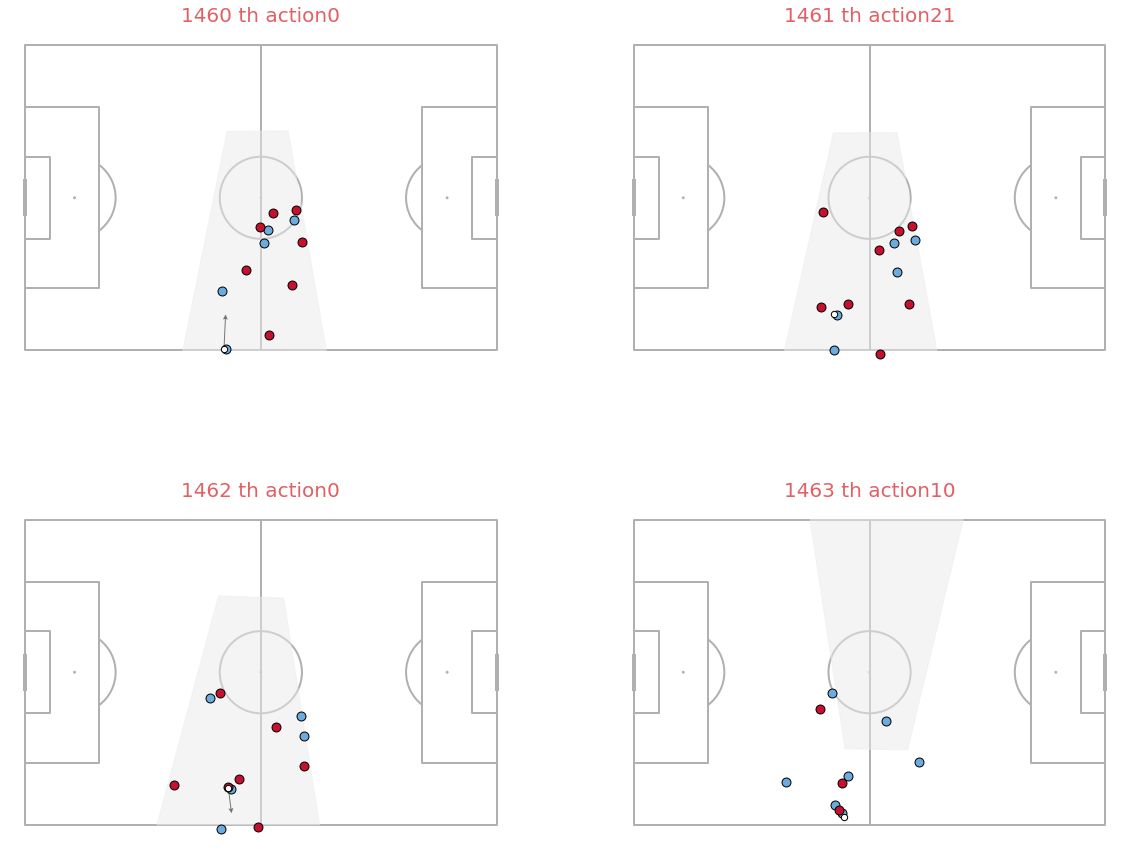

In [54]:
game_id = 3788751	
action_id = [1460, 1461, 1462, 1463]
ex_action = db.actions(game_id=game_id)
fig, ax = plt.subplots(2,2,figsize=(20,16))

ax_id = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]] 


for i in range(len(action_id)):
    type_id = str(ex_action.loc[(game_id,action_id[i])]['type_id'])

    plot_action(ex_action.loc[(game_id,action_id[i])], ax=ax_id[i])
    
    title = str(action_id[i]) + " th action" + type_id
    ax_id[i].set_title(title,color='#e35f62',fontsize=20)

plt.show()

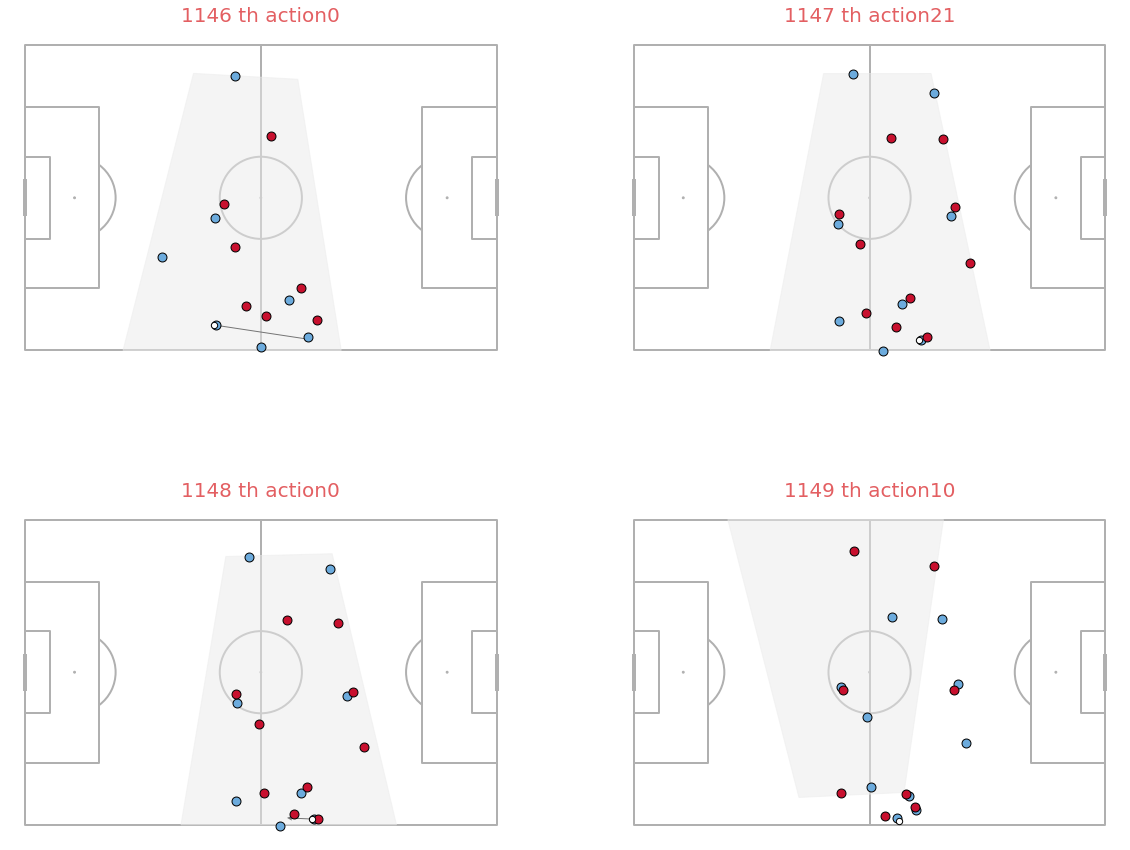

In [52]:
game_id = 3869684	
action_id = [1146, 1147, 1148, 1149]
ex_action = db.actions(game_id=game_id)
fig, ax = plt.subplots(2,2,figsize=(20,16))

ax_id = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]] 


for i in range(len(action_id)):
    type_id = str(ex_action.loc[(game_id,action_id[i])]['type_id'])

    plot_action(ex_action.loc[(game_id,action_id[i])], ax=ax_id[i])
    
    title = str(action_id[i]) + " th action" + type_id
    ax_id[i].set_title(title,color='#e35f62',fontsize=20)

plt.show()

In [59]:
db.close()